# クラスタリングの評価

今まではGMM(Gaussian Mixture Model: 混合ガウス分布モデル)を主に使用していた。GMMはDistribution系(分布系)のクラスタリングアルゴリズムであり、確率密度(正確には尤度)を使用したBICによる評価は、自然な評価である。  
しかしながら、Centroid系(重心系)やConnectivity系(階層クラスタリング系)など、他のクラスタリングではBICを直接使用することはできず、別の評価方法が必要となる。そのうちの一つとして紹介したのがDunn Indexであった。    
ここでは、Dunn Indexを含めた各種評価方法を、実際のPythonコードと一緒に紹介していく。

## Pseudo F (またはCalinski-Harabaszスコア、またはVariance Ratio基準)

全体分散をクラスター内分散で割った値。より具体的には、以下の式で与えられる。**大きいほど良い。**

$\begin{eqnarray}Pseudo F &=& \frac{クラスター間分散}{クラスター内分散}\\
&=& \frac{\sum_{k=1}^K (c_k - c_{all})^2 / (K-1)}{\sum_{k=1}^K \sum_{i=1}^{n_k}(x_{i,k} - c_k)^2 / (N-K)}
\end{eqnarray}$

ただし、
- $K$ : クラスター数
- $N$ : サンプル数
- $n_k$ : クラスター$k$に属するサンプル数
- $c_k$ : クラスター$k$の重心
- $c_{all}$ : 全サンプルの重心
- $x_{i,k}$ : クラスター$k$に属する$i$番目のサンプル

sklearnでは、`sklearn.metrics.calinski_harabasz_score`を使用して計算できる。へっこんだ部分のある凹型のクラスターを悪いクラスターと捉える傾向がある。

In [1]:
from sklearn import metrics, cluster
from sklearn.datasets import load_diabetes
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=("age", "sex", "bmi", "map", "tc",
                                          "ldl", "hdl", "tch", "ltg", "glu"))

In [4]:
X = df[["glu", "bmi"]]
X = (X - X.mean())/X.std()

[Text(0.5, 1.0, 'Ward: score=262')]

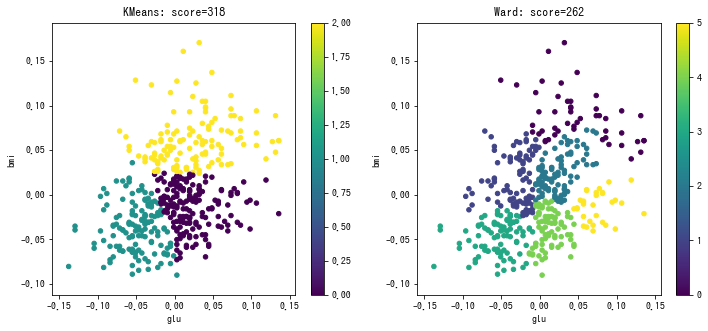

In [5]:
m1 = cluster.KMeans(n_clusters=3)
m2 = cluster.AgglomerativeClustering(6)
labels1 = m1.fit_predict(X)
labels2 = m2.fit_predict(X)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
df.plot.scatter(x="glu", y="bmi", c=labels1, colormap="viridis", ax=ax)
score1 = metrics.calinski_harabasz_score(X, labels1)
ax.set(title=f"KMeans: score={score1:.0f}")
ax = fig.add_subplot(1,2,2)
df.plot.scatter(x="glu", y="bmi", c=labels2, colormap="viridis", ax=ax)
score2 = metrics.calinski_harabasz_score(X, labels2)
ax.set(title=f"Ward: score={score2:.0f}")

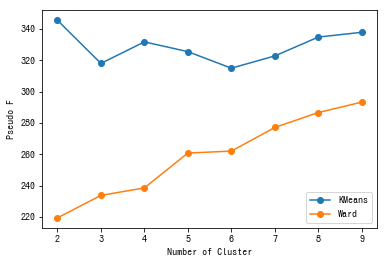

In [6]:
scores_PF_KMeans = [metrics.calinski_harabasz_score(X, 
                        cluster.KMeans(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
scores_PF_Ward = [metrics.calinski_harabasz_score(X, 
                        cluster.AgglomerativeClustering(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
plt.plot(range(2,10), scores_PF_KMeans, "o-", label="KMeans")
plt.plot(range(2,10), scores_PF_Ward, "o-", label="Ward")
plt.legend()
plt.xlabel("Number of Cluster")
plt.ylabel("Pseudo F")
plt.xticks(range(2,10));

KMeansのクラスタ数2が良さそうである。

## Davies-Bouldinスコア(またはDBインデックス)

DBインデックスも、クラスタ内距離とクラスタ間距離の両方を考慮したインデックスである。<font color=red>**小さいほどが良い。**</font>

具体的には、あるクラスターについて、他のクラスターに対するクラスター内距離/クラスタ間距離を計算し、その最大値をそのクラスタのスコア$R$とする。全てのクラスタについて$R$を計算し、単純平均をとった値がDBインデックスである。

数式で書くと、以下のようになる。

$$DB's Index = \frac{1}{K} \sum_{k=1}^{K} R_k$$
$$R_k = \max \left \{ \frac{S_k + S_j}{d(c_k, c_j)} \right \} (j=1,2,...,K, j≠k)$$
$$S_k = \frac{1}{n_k} \sum_{i=1}^{n_k} d(x_{i,k}, c_k)$$

ただし、
- $K$ : クラスター数
- $S_k$ : クラスター$k$のクラスター内距離
- $R_k$ : クラスター$k$のスコア
- $n_k$ : クラスター$k$に属するサンプル数
- $c_k$ : クラスター$k$の重心
- $x_{i,k}$ : クラスター$k$に属する$i$番目のサンプル
- $d(x, y)$ : 点$x$と点$y$の距離

最終的には単純平均をとっているので、クラスターの大小は考慮されない。また、各クラスターのスコアも最大値を取っているので、遠く離れたクラスターのペアがあると、良いスコアが出る。結果、クラスター数が多いものを「良し」とする傾向があるため、できれば同じクラスター同士の比較で用いることが望ましい。  
また、へっこんだ部分のある凹型のクラスターを悪いクラスターと捉える傾向がある。  
sklearnでは、`sklearn.metrics.davies_bouldin_score`を使用して計算できる。

[Text(0.5, 1.0, 'Ward: score=0.9450')]

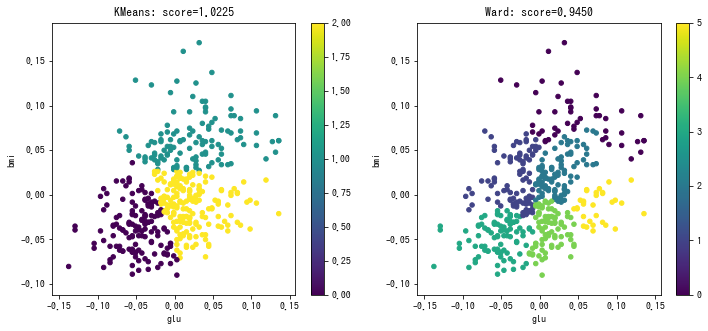

In [7]:
m1 = cluster.KMeans(n_clusters=3)
m2 = cluster.AgglomerativeClustering(n_clusters=6)
labels1 = m1.fit_predict(X)
labels2 = m2.fit_predict(X)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
df.plot.scatter(x="glu", y="bmi", c=labels1, colormap="viridis", ax=ax)
score1 = metrics.davies_bouldin_score(X, labels1)
ax.set(title=f"KMeans: score={score1:.4f}")
ax = fig.add_subplot(1,2,2)
df.plot.scatter(x="glu", y="bmi", c=labels2, colormap="viridis", ax=ax)
score2 = metrics.davies_bouldin_score(X, labels2)
ax.set(title=f"Ward: score={score2:.4f}")

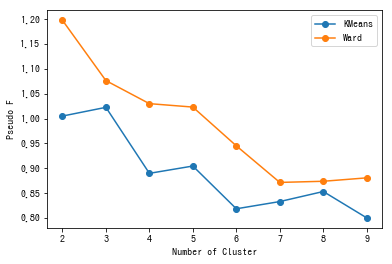

In [8]:
scores_DB_KMeans = [metrics.davies_bouldin_score(X, 
                        cluster.KMeans(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
scores_DB_Ward = [metrics.davies_bouldin_score(X, 
                        cluster.AgglomerativeClustering(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
plt.plot(range(2,10), scores_DB_KMeans, "o-", label="KMeans")
plt.plot(range(2,10), scores_DB_Ward, "o-", label="Ward")
plt.legend()
plt.xlabel("Number of Cluster")
plt.ylabel("Pseudo F")
plt.xticks(range(2,10));

Kmeansの方が良さそうである。DBインデックスは、基本的にクラスタ数が多いほど小さくなるので、どのクラスタ数が良いかは判断できない。

## 平均シルエット係数

各サンプルのシルエット係数は、「クラスター内のサンプルとの平均距離」と、「隣のクラスターのサンプルとの平均距離」の差から計算される。全てのサンプルについてシルエット係数の平均をとった値が平均シルエット係数である。-1から1の値を取る。**大きいほど良い。**  
具体的には、以下のように計算される。

$$s_{all} = \frac{1}{N}\sum_i^{N} s_i$$
$$s_i = \frac{b_i - a_i}{max(a_i,b_i)}$$

$$a_i = \frac{1}{n_k} \sum_{j=1}^{n_k} d(x_{i,k}, x_{j,k})$$

$$b_i = \frac{1}{n_m} \sum_{j=1}^{n_m} d(x_{i,k}, x_{j,m})$$

ただし、
- $s_{all}$ : 平均シルエット係数
- $s_i$ : サンプル$i$のシルエット係数
- $R_k$ : クラスター$k$のスコア
- $n_k$ : クラスター$k$に属するサンプル数
- $x_{i,k}$ : クラスター$k$に属する$i$番目のサンプル
- $d(x, y)$ : 点$x$と点$y$の距離
- $a_i$ : サンプル$i$と、同一クラスター内の他のサンプルとの平均距離
- $b_i$ : サンプル$i$と、隣のクラスター内のサンプルとの平均距離(隣のクラスター = 最も近い他のクラスター)
- 上の式において、クラスター$k$と、クラスター$m$は隣のクラスターである。

sklearnでは、`sklearn.metrics.silhouette_score`を使用して計算できる。へっこんだ部分のある凹型のクラスターを悪いクラスターと捉える傾向がある。

[Text(0.5, 1.0, 'Ward: score=0.3069')]

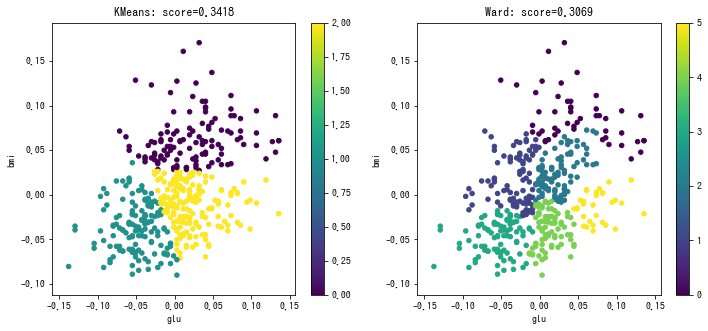

In [9]:
m1 = cluster.KMeans(n_clusters=3)
m2 = cluster.AgglomerativeClustering(n_clusters=6)
labels1 = m1.fit_predict(X)
labels2 = m2.fit_predict(X)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
df.plot.scatter(x="glu", y="bmi", c=labels1, colormap="viridis", ax=ax)
score1 = metrics.silhouette_score(X, labels1)
ax.set(title=f"KMeans: score={score1:.4f}")
ax = fig.add_subplot(1,2,2)
df.plot.scatter(x="glu", y="bmi", c=labels2, colormap="viridis", ax=ax)
score2 = metrics.silhouette_score(X, labels2)
ax.set(title=f"Ward: score={score2:.4f}")

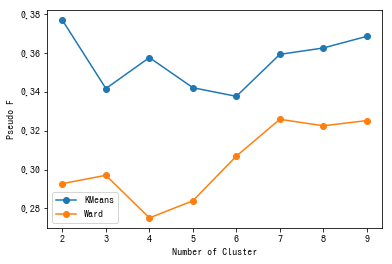

In [10]:
scores_silhouette_KMeans = [metrics.silhouette_score(X, 
                        cluster.KMeans(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
scores_silhouette_Ward = [metrics.silhouette_score(X, 
                        cluster.AgglomerativeClustering(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
plt.plot(range(2,10), scores_silhouette_KMeans, "o-", label="KMeans")
plt.plot(range(2,10), scores_silhouette_Ward, "o-", label="Ward")
plt.legend()
plt.xlabel("Number of Cluster")
plt.ylabel("Pseudo F")
plt.xticks(range(2,10));

Kmeansのクラスタ数2が良さそうである。

## Dunn Index

Dunn Indexはクラスター内距離の最大値とクラスター間距離の最小値の比である。すなわち、

$\begin{eqnarray}Dunn Index &=& \frac{min(クラスター間距離)}{max(クラスター内距離)} 
\end{eqnarray}$

sklearnにはまだ実装されていないが、比較的簡単にpythonで関数を作成できる。  
Dunn Indexには、クラスタ内距離やクラスタ間距離の定義の仕方が複数存在するため、いくつかのバリエーションがある。  
ここでは、クラスタ内距離として重心との距離の平均値を、クラスタ間距離としてクラスタの重心間の距離を使用した。

In [13]:
import numpy as np

def dunn_index(df_X, labels):
    centroids = [] # 重心
    inner_distances = [] # クラスタ内距離
    label_list = np.unique(labels) # ラベルの種類一覧
    
    for k in label_list: # ラベル(クラスタ)毎に処理
        X_tmp = df_X[labels==k].values
        centroids.append(X_tmp.mean(axis=0)) # クラスタの重心を計算
        # クラスタ内距離を計算
        inner_distances.append((np.abs(X_tmp - X_tmp.mean(axis=0))).mean())

    inter_distances = [] # ward距離
    for i,k in enumerate(label_list): # クラスタA
        for j,k in enumerate(label_list): # クラスタB
            if i < j: # クラスタが異なるときに計算(かつ、ダブリを回避)
                inter_distances.append((np.abs(centroids[i] - centroids[j])).sum())
    return min(inter_distances)/max(inner_distances)

[Text(0.5, 1.0, 'Ward: score=2.1111')]

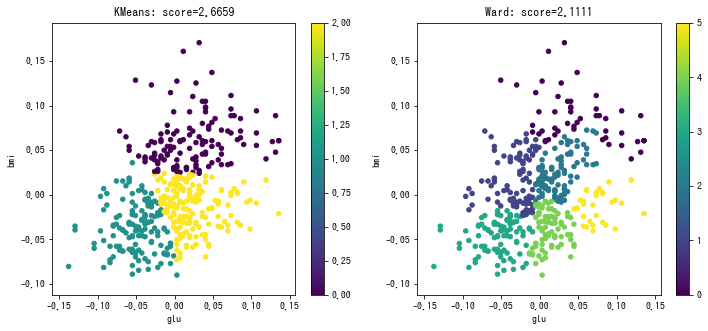

In [14]:
m1 = cluster.KMeans(n_clusters=3)
m2 = cluster.AgglomerativeClustering(n_clusters=6)
labels1 = m1.fit_predict(X)
labels2 = m2.fit_predict(X)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
df.plot.scatter(x="glu", y="bmi", c=labels1, colormap="viridis", ax=ax)
score1 = dunn_index(X, labels1)
ax.set(title=f"KMeans: score={score1:.4f}")
ax = fig.add_subplot(1,2,2)
df.plot.scatter(x="glu", y="bmi", c=labels2, colormap="viridis", ax=ax)
score2 = dunn_index(X, labels2)
ax.set(title=f"Ward: score={score2:.4f}")

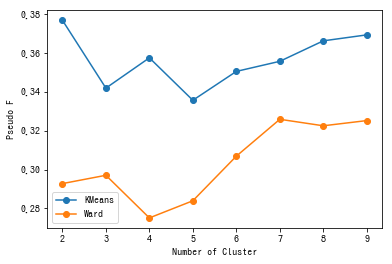

In [15]:
scores_Dunn_KMeans = [metrics.silhouette_score(X, 
                        cluster.KMeans(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
scores_Dunn_Ward = [metrics.silhouette_score(X, 
                        cluster.AgglomerativeClustering(n_clusters=i).fit_predict(X))
                    for i in range(2,10)]
plt.plot(range(2,10), scores_Dunn_KMeans, "o-", label="KMeans")
plt.plot(range(2,10), scores_Dunn_Ward, "o-", label="Ward")
plt.legend()
plt.xlabel("Number of Cluster")
plt.ylabel("Pseudo F")
plt.xticks(range(2,10));

クラスタ数2のKMeansが良さそうである。

## エルボープロット

この方法は具体的な数値ではなくグラフを見て、最終的には分析者の主観で判断する方法である。(主観で判断することは悪いことではない。難点としては、自動化が難しいことである。)

クラスタ数を決めるための評価指標であり、同一のアルゴリズムで、どのクラスタ数が良さそうを判断するために用いる。
異なるアルゴリズム間で、どちらのアルゴリズムが良さそうかを判断する際には使用できない。

In [16]:
# innertiaを計算する関数
def calc_innertia(df_X, labels):
    inner_SSE = [] # クラスタ内距離
    label_list = np.unique(labels) # ラベルの種類一覧
    
    for k in label_list: # ラベル(クラスタ)毎に処理
        X_tmp = df_X[labels==k].values
        # クラスタ内で、クラスタ重心と各サンプルの距離の二乗和を計算
        inner_SSE.append(((X_tmp - X_tmp.mean(axis=0))**2).sum())

    return sum(inner_SSE)

In [19]:
# クラスタ数 1 ~ 20でinnertiaを計算
innertias = []
for i in range(1,20):
    tmp_label = cluster.KMeans(n_clusters=i).fit_predict(X)
    innertias.append(calc_innertia(X, tmp_label))

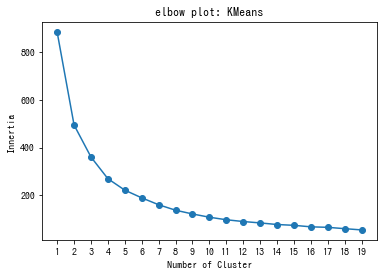

In [20]:
plt.plot(range(1,20), innertias, "o-")
plt.title("elbow plot: KMeans")
plt.xlabel("Number of Cluster")
plt.ylabel("Innertia")
plt.xticks(range(1,20));

クラスタ数4まではInnertiaが良く減るが、5以降に増やしてもそれほど減らないので、クラスタ数4が良さそうである。

**宿題**

13.1の宿題では、6つのセンサーペアについて、5つのアルゴリズムでクラスタリングを行った。  
本notebookで紹介した各指標(DBスコアを除く)を用いて、13.1のクラスタリング結果について評価、考察せよ。

-----(以下再掲) 宿題13.1-----

- センサーデータについて、以下の6つのペアについて、以下の各アルゴリズムで4つのクラスタにクラスタリングし、その結果を散布図で描写してください。
    - KMeans
    - GMM
    - 階層クラスタリング(Ward法)
    - DBSCAN
    - 階層クラスタリング(平均法)
        - cluster.AgglomerativeClusteringにおいて、linkage="average"と指定してください。

- センサーのペア
    - ("Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)")
    - ("Engine Speed", "Yaw Rate 1(learmed data)")
    - ("Engine Speed", "Vehicle Speed")
    - ("Lateral Sensor Value", "Yaw Rate 1(learmed data)")
    - ("Vehicle Speed", "Turn Left SW")
    - ("Fuel Level Percent Average", "Acceleration Sensor Value")

- DBSCANはクラスタ数は指定できないので、適当なepsを与えてクラスタリングしてください。
- 正規化を掛けたのち、クラスタリングを行ってください。

In [21]:
# データを読み込む
import pandas as pd
import numpy as np


df_raw = pd.read_csv("../data/interim/20190605_CAN/103.486_CAR1V21_HDD2/Job1/"
                     + "SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                     names=['vin', 'time1', 'time2', 'feature', 'value'])

# 読み替え表データ
df_feature_name = pd.read_csv("../data/interim/20190605_CAN/20190617_featureName.csv")
df_feature_name["key"] = df_feature_name["key"].str[2:]
feature_name_dict = df_feature_name.set_index("key")["featureName"].to_dict()

# 集約して横持ちに
df = (
    df_raw
    .assign(rounded_time2=np.round(df_raw.time2, 1)) # time2を小数点以下1桁(0.1)で丸めて rounded_time2 列とする
    .groupby(["vin", "time1","rounded_time2","feature"])["value"].median() # 中央値で集約
    .unstack(level=-1) # feature列について横積みにする
    .interpolate() # NA を線形補完する
    .dropna() # 残った NA （先頭にNAがあったケース）を除外する
)

# 読み替え
df = df.rename(columns=feature_name_dict)

In [22]:
# ペア一覧
sensor_pairs = [
    ["Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)"],
    ["Engine Speed", "Yaw Rate 1(learmed data)"],
    ["Engine Speed", "Vehicle Speed"],
    ["Lateral Sensor Value", "Yaw Rate 1(learmed data)"],
    ["Vehicle Speed", "Turn Left SW"],
    ["Fuel Level Percent Average", "Acceleration Sensor Value"],
]

In [23]:
# 試しに1ペア取り出す
df[["Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)"]].head()

feature                         Steering Wheel Absolute Angle  \
vin time1        rounded_time2                                  
21  201604200627 0.9                                     -7.7   
                 1.0                                     -7.7   
                 1.1                                     -7.7   
                 1.2                                     -7.7   
                 1.3                                     -7.7   

feature                         Yaw Rate 1(learmed data)  
vin time1        rounded_time2                            
21  201604200627 0.9                                0.00  
                 1.0                                0.03  
                 1.1                                0.01  
                 1.2                                0.03  
                 1.3                                0.02